In [7]:
!pip install peft
!pip install -U bitsandbytes

In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer,BitsAndBytesConfig
import torch 

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)
base_model = 'model-attribution-challenge/bloom-2b5'
model = AutoModelForCausalLM.from_pretrained(base_model,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch.float16,
                                             device_map='auto'
                                            )
tokenizer = AutoTokenizer.from_pretrained(base_model)


In [ ]:
tokenizer.all_special_ids

In [ ]:
model

In [ ]:
#QLoRA
from peft import get_peft_model, LoraConfig, PeftModel, prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)
config = LoraConfig(
    r=16,
    lora_alpha=32,
    bias='none',
    lora_dropout=0.05,
    task_type='CAUSAL_LM',
    target_modules=['dense', 'query_key_value'],
)

lora_model = get_peft_model(model, config)

In [ ]:
#sô lượng tham số cần train
lora_model.print_trainable_parameters()

In [ ]:
pip install datasets

In [ ]:
from datasets import Dataset, concatenate_datasets

paths = ['/kaggle/input/data-qa-python-06102004/Data-QA-Python.csv', '/kaggle/input/data-qa-py/data-gpt-create-6-10-2024.csv', '/kaggle/input/datasetqapy/python_questions_answers.csv']
df = []
for path in paths:
    data = Dataset.from_csv(path)
    try:
        df.append(data.rename_columns({'Question': 'question', 'Answer':'answer'}))
    except:
        df.append(data)

df = concatenate_datasets(df).shuffle()

In [ ]:
df['question']

In [ ]:
# chuẩn hóa question answer thành 1 câu hoàn chỉnh
# '<s>[INST]' + example['question'] + ' ?  \n[/INST] ' + example['answer'] + .</s>
# Đồng thời loại bỏ câu nào có số lượng token > 600 
import time

def tokenizer_function(example):
    prompt = ['<s>[INST]' + val['question'] + ' ?  \n[/INST] ' + val['answer'] + ".</s>" for val in example]
    x = [key for key, i in enumerate(prompt) if len(tokenizer.tokenize(i)) >= 600 and i[-1] != '?']
    print(len(x))
    y = [i for i in example['answer'] if i[-1] == '?']
    print(len(y))
    prompt = [i for i in prompt if len(tokenizer.tokenize(i)) < 600]
    example = [i for key, i in enumerate(example['answer']) if key not in x]
    print(example[:1])
    inputs = tokenizer(prompt, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
    labels = tokenizer(example, padding='max_length', truncation=True, max_length=600, return_tensors='pt')
    inputs['labels'] = labels['input_ids']
    return inputs

st  = time.time()
token_df = tokenizer_function(df)
print(time.time() - st)

In [ ]:
#đưa dataset về dạng tensor để tính toán nhanh hơn
token_df.set_format(type='torch', columns=['input_ids', 'attention_mask'])
type(token_df['input_ids'])

In [ ]:
token_df[:1]

In [ ]:
#chia tập dataset ra thành tập train và tập evaluation và chuyển về dạng tensor

from sklearn.model_selection import train_test_split

train , eval_ = train_test_split(token_df, test_size=0.20, random_state=42)

train = Dataset.from_dict(train)
train.set_format(type='torch', columns=['input_ids', 'attention_mask'])
print(train)

eval_ = Dataset.from_dict(eval_)
eval_.set_format(type='torch', columns=['input_ids', 'attention_mask'])

In [ ]:
#huận luyện trên tập train
from transformers import TrainingArguments, Trainer

agrs = TrainingArguments(
    output_dir = './result',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    # gradient_accumulation_steps=12,
    learning_rate=2e-4,
    weight_decay=4e-4,
    eval_strategy='steps',
    eval_steps=100,
    logging_dir='./loss',
    logging_steps=100,
    num_train_epochs=2,
    fp16=True,
)

trainer = Trainer(
    model=lora_model,
    args=agrs,
    train_dataset=token_df,
    eval_dataset=eval_,
    data_collator=data_collator,
)

trainer.train()

In [ ]:
#lưu adapter QloRA
lora_model.save_pretrained('adapter', save_adapter=True,save_config =True)

In [ ]:
pip install peft

In [ ]:
from peft import PeftModel
from transformers import AutoTokenizer, AutoModelForCausalLM

# model = AutoModelForCausalLM.from_pretrained("model-attribution-challenge/bloom-2b5")
# tokenizer = AutoTokenizer.from_pretrained('model-attribution-challenge/bloom-2b5', return_tensors='pt', padding='max-length', max_length=512)

model_lora = PeftModel.from_pretrained(model, '/kaggle/input/qlora-new-new-new/transformers/default/1')
# model.merge_and_unload()

# model.save_pretrained('merged-model')

In [ ]:
# import time

# def input_sent(prompt):
#     # while True:
#       # prompt = input("Bạn: ")
#       prompt = prompt[0].upper() + prompt[1:]
#       prompt = prompt.strip()
#       st = time.time()
#       if prompt.lower() == 'exit':
#         return
#       prompt = '<s>[INST]' + prompt + ' ?  \n[/INST] '
#       # model_lora.to('cuda')
#       inputs = tokenizer(prompt, return_tensors='pt')
#       output = model_lora.generate(
#           **inputs,
# #           max_length=50,
#           min_length=20,
#           max_new_tokens=512,
#           # top_k = 10,
#           # top_p = 0.95,
#           # do_sample=True,
#           repetition_penalty=1.05,
          
#         )
#       print(tokenizer.decode(output[0], skip_special_tokens=True).replace('\\n', '\n').replace('\\t', '\t')) 
#       print(time.time() - st)


In [ ]:
# questions = [
#     "1. Python là gì? Tại sao Python được sử dụng phổ biến?",
#     "2. Làm thế nào để cài đặt Python trên máy tính?",
#     "3. Biến trong Python là gì? Cách khai báo biến?",
#     "4. Sự khác biệt giữa Python 2 và Python 3 là gì?",
#     "5. Các kiểu dữ liệu cơ bản trong Python là gì?",
#     "6. Làm thế nào để tạo một list và thêm phần tử vào list?",
#     "7. Sự khác biệt giữa list và tuple trong Python?",
#     "8. Lambda function là gì? Khi nào nên sử dụng nó?",
#     "9. Sự khác biệt giữa `==` và `is` trong Python là gì?",
#     "10. Làm thế nào để đọc và ghi file trong Python?",
#     "11. Exception handling trong Python là gì? Sử dụng `try`, `except`, `finally` như thế nào?",
#     "12. Làm thế nào để định nghĩa một hàm (function) trong Python?",
#     "13. Làm thế nào để sử dụng vòng lặp `for` và `while` trong Python?",
#     "14. List comprehension là gì? Tại sao nên sử dụng nó?",
#     "15. Sự khác biệt giữa `break`, `continue` và `pass` trong vòng lặp?",
#     "16. Module và package trong Python là gì? Làm thế nào để sử dụng chúng?",
#     "17. Sự khác biệt giữa hàm `append()` và `extend()` của list?",
#     "18. Làm thế nào để cài đặt và sử dụng các thư viện bên ngoài bằng `pip`?",
#     "19. Decorator trong Python là gì? Khi nào nên sử dụng decorator?",
#     "20. Sự khác biệt giữa mutable và immutable trong Python?"
# ]

# for idx, question in enumerate(questions, start=1):
#     input_sent(question)

# # input_sent()

In [ ]:
pip install pyngrok

In [ ]:
#tạo api để backend call đến

from flask import Flask, request, jsonify
from pyngrok import ngrok
import torch 
import time 

app = Flask(__name__)

@app.route('/', methods=['POST'])
def predict():
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  st = time.time()
  data = request.get_json()['input']
  data = '<s>[INST]' + data + ' ?  \n[/INST] '
  inputs = tokenizer(data, return_tensors='pt').to(device)
  model_lora.to(device)
  out = model_lora.generate(
      **inputs,
      # top_p = 0.98,
      # top_k = 5,
      # do_sample=True,
      repetition_penalty = 1.05,
      min_length=16,
      max_new_tokens=512,
  )
  response = tokenizer.decode(out[0], skip_special_tokens=True).strip()
  end = time.time()
  print(response, end - st)
  return jsonify({
      'response':response.replace('\\n', '\n').replace("\\t", "\t")
  })

if __name__ == '__main__':
  ngrok.set_auth_token("2nhtFTDawpLWhCa1mGsa6FRypDr_21pThTGDw9h8sNgAabSv")
  ngrok_tunnel = ngrok.connect(5000)
  print('Public URL:', ngrok_tunnel.public_url)#api
  app.run()


In [3]:
import pandas as pd

df = pd.read_csv('/kaggle/input/loss-3-epochs/loss.csv').drop(columns=['Unnamed: 0'])

df

,step,train,eval
0,100.0,1.4558,1.364186
1,200.0,1.3371,1.293669
2,300.0,1.2729,1.254839
3,400.0,1.2363,1.207342
4,500.0,1.2044,1.168903
5,600.0,1.1728,1.147625
6,700.0,1.1225,1.115785
7,800.0,1.1333,1.113178
8,900.0,1.0959,1.089114
9,1000.0,1.0918,1.081987


In [4]:
x = df['step']
y = df[['train', 'eval']]

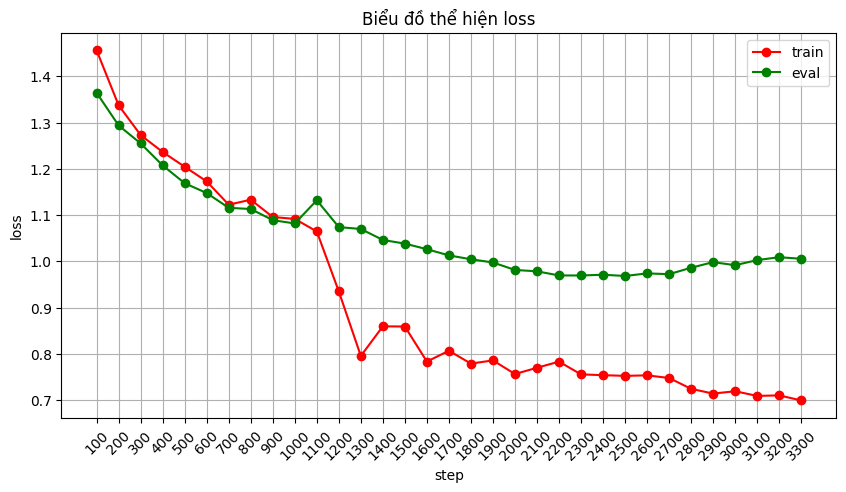

In [6]:
import matplotlib.pyplot as plt

plt.figure(1, (10, 5))
plt.title('Biểu đồ thể hiện loss')
plt.plot(x, y['train'], 'r-', marker='o', label='train')
plt.plot(x, y['eval'], 'g-', marker='o', label='eval')
plt.xlabel('step')
plt.ylabel('loss')
plt.xticks(x, rotation=45)
plt.grid()
plt.legend()

plt.show()